# Práctica Métodos de Simulación - Parte 3

## Elena Rivas, Teresa Grau, Ignacio Casso

## Enunciado

**El problema de las n reinas.**

El problema de las n-reinas consiste en colocar n reinas en un tablero de ajedrez de
n x n de tal manera que no sea posible que dos reinas se capturen entre si, es decir,
que no estén en la misma fila, ni en la misma columna ni en la misma diagonal. Se
dice que hay una colisión si hay dos reinas que se pueden capturar entre si.

Se trata pues de encontrar una configuración (elegir las n celdas donde colocar a las
reinas) que minimice el número total de colisiones. Obtener la solución óptima para
n=9.

Mostrar gráficamente la evolución del valor de la función fitness y del parámetro
temperatura considerados a lo largo de las iteraciones de la metaheurı́stica.

**Enfriamiento simulado**

El enfriamiento simulado (SA, *Simulated Annealing*) es una técnica de optimización combinatorial que se usa para afrontar problemas de gran complejidad matemática, de modo que se obtengan soluciones cercanas a la óptima. Se fundamenta en el proceso físico de calentamiento de un sólido, seguido por un enfriamiento hasta lograr un estado cristalino con una estructura perfecta. Durante este proceso, la energía libre del sólido es minimizada y de esta forma se obtine un material con mejores propiedades.

El enfriamenteo simulado es un metodo iterativo que inicia con un cierto estado $s$. Mediante un proceso particular genera un estado vecino $s'$ al estado actual. Si la energía, o evaluación, del estado $s'$ es menor que la del estado $s$, se cambia el estado $s$ por $s'$. Si la evaluación de $s'$ es mayor que la de $s$ entonces se puede emperorar eligiendo $s'$ en lugar de $s$ con una cierta probabilidad, que depende de la diferencia de las evaluaciones $∆f = f(s) − f(s')$ y de la temperatura actual del sistema, $T$. 
La posibilidad de elegir un estado peor al actual es lo que le permite a SA salir de óptimos locales para poder llegar a los óptimos globales. La probabilidad de aceptar elegir un peor estado normalmente se calcula por la fórmula:

$$P(∆f, T) = e^{∆f/T}$$

Una cualidad de SA es que la temperatura va disminuyendo gradualmente conforme avanza la simulación. Al principio del proceso la temperatura se inicializa a un valor bastante alto, de esta forma, la probabilidad de poder aceptar peores soluciones es alta. Esto permite explorar un amplio espacio de soluciones y evitar quedar atrapado en un optimo local.

Según pasan las iteraciones, la temperatura desciende, disminuyendo la probabilidad de que se acepte una solución peor a la actual, por lo que deja de explorar y comienza a intensificar la búsqueda para que se produzca la convergencia hacia la solución óptima. Es decir, se hace más selectiva la aceptación de una nueva solución y al final, sólo se aceptan movimientos que mejoran la solución actual.

El siguiente pseudocódigo representa una versión general del algoritmo de enfriamiento simulado:

In [1]:
s = GeneraUnaSolucionInicial()
T = T_0
g = 0
while(CondicionesParadaNoActivas(g, T)):
    s1 = TomaUnVecinoAleatorioDe(s) #s1 es s'
    if f(s1)<f(s):
        s = s1
    else:
        if Random(0,1.0)<exp((f(s)-f(s1))/T):
            s = s1
    g = g+1
    T = Actualiza(g, T)      

NameError: name 'GeneraUnaSolucionInicial' is not defined

## Planteamiento

#### El problema de las n reinas se puede plantear de dos maneras: 

- A) ubicando n reinas de manera que se minimicen las colisiones 
- B) maximizar el número de reinas en el tablero sujeto a la restricción de que no existan colisiones

## Soluciones

En esta práctica nos vamos a centrar en el planteamiento decrito anteriormente como A), para el que queremos minimizar el número de colisiones entre las reinas. Para éste proponemos dos implementaciones distintas para el algoritmo de enfriamiento simulado, que se diferencian en el espacio de búsqueda y en la codificación de las soluciones:
- A1)  En esta solución consideramos todo el espacio de búsqueda, es decir, todas las posibles configuraciones del tablero con $n$ reinas en él. 
- A2) En este caso tenemos en cuenta que por necesidad debe haber una reina en cada fila y otra en cada columna, y codificamos las soluciones como permutaciones de $n$ elementos, reduciendo el espacio de soluciones de un cardinal de $(n^2)^n$ a uno de $n!$. 

Para cada una de ellas se exploran distintas elecciones de parámetros y los resultados que se obtienen.

In [7]:
from random import random, randint
import bisect
import numpy as np
import matplotlib.pyplot as plt

## Caso A1) Consideramos todas las posibles configuraciones del tablero con n reinas.

### Codificación de las soluciones

Codificaremos las soluciones como listas de 9 posiciones, siendo cada posición una tupla de 2 elementos. Para evitar redundancia en la codificación, se impone que esa lista esté ordenada (lexicográficamente), y para evitar soluciones no factibles, se prohiben los elementos repetidos en una lista.

### Función objetivo

La función objetivo a minimizar será el número de colisiones entre reinas, es decir, el número de pares distintos de reinas que están en la misma diagonal. La siguiente función implementa el cálcula de esa función de fitness

In [8]:
def num_collisions(positions):
    
    if positions==[]:
        return 0
    else:
        queen, positions2 = positions[0], positions[1:]
        num_colls = 0
        for queen2 in positions2:
            if collision(queen,queen2):
                num_colls += 1
        return num_colls + num_collisions(positions2)
    
def collision(queen1,queen2):
    i1,j1 = queen1
    i2,j2 = queen2
    
    if i1==i2 or j1==j2 or i1-j1==i2-j2 or i1+j1==i2+j2: # same row, same column, same descending diagonal, same ascending diagonal
        return True
    else:
        return False

### Entorno de un punto en el espacio de búsqueda

Proponemos los siguientes entornos para una solución:

El primero, las soluciones obtenidas al mover una reina una posición en cualquier dirección.

In [9]:
moves = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]

def oneRandomMove(sol,n):
    i = randint(0,n-1) # random index
    qx,qy = sol[i] # queen with that random index
    new_sol = sol[:i] + sol[i+1:] # copy of previous list of queens without selected one
    indexes = np.random.permutation(8) # indexes 0..7 in random order
    for j in indexes:
        mx,my = moves[j] # random move
        nqx,nqy = qx+mx, qy+my
        if 0<nqx and 0 < nqy and n >= nqx and n>=nqy: # move does not take the queen out of the board
            new_pos = nqx,nqy
            k = bisect.bisect(new_sol, new_pos)
            if i==0 or sol[i-1] != new_pos: # new position is not occupied by another queen
                bisect.insort(new_sol,new_pos) # new position inserted, maintaining order in the list
                return new_sol

El segundo, las soluciones obtenidas al recolocar una reina en una posición aleatoria del tablero.

In [10]:
def oneRandomRelocation(sol,n):
    i = randint(0,n-1) # random index
    new_sol = sol[:i] + sol[i+1:] # list of queens without the one with that random index
    while True: # until the new position is valid
        new_pos = randint(1,n), randint(1,n) # new position
        i = bisect.bisect(new_sol, new_pos)
        if i==0 or sol[i-1] != new_pos: # new position is not occupied by another queen
            bisect.insort(new_sol,new_pos)
            return new_sol

Es fácil observar que ambas alternativas pueden quedarse atascadas en mínimos locales. Por ejemplo, si tenemos una solución sólo con un conflicto diagonal (con una reina en cada fila y columna), cambiar una sóla reina de sitio nunca mejorará el fitness, sea cual sea la posición del tablero a la que se mueva, ya que o bien se mueve a una fila o columna ocupadas, y sigue habiendo un conflicto, o se queda dónde esta, en la única fila y columna libres. Aún así hemos decidido mantener esta elección de entornos.

Por otro lado, tanto las alternativas propuestas como cualquier otra basada en mover reinas aleatorias, pueden mejorarse dando mayor probabilidad de ser movidas a las reinas que están en situación de colisión. Hemos optado por no implementar esta mejora, y no hacer depender la elección de una solución vecina del fitness de la solución actual

### Valor inicial de la temperatura

La temperatura debe ser tal en el proceso que permita una adecuada exploración en las diferentes etapas del enfriamiento simulado. Existen diferentes formas para calcular la temperatura inicial, siendo una de ellas simular el proceso para la primera cadena de Markov.  **???**

Para este caso vamos a proponer varios valores iniciales de temperatura y obtener el mejor empíricamente

### Variación de la temperatura

Proponemos las siguientes actualizaciones de temperatura:

En primer lugar, la propuesta en las transparencias, con $L=10,~ \alpha = 0.95$

In [11]:
def updateTempStandard(T,i):
    if i%10 == 0:
        newT = 0.95*T
    else:
        newT = T
    return newT

### Probabilidad de aceptación de nuevas soluciones

En este caso proponemos la estándar:

In [12]:
from math import exp

In [13]:
def prob_aceptacion_standard(f1,f,T):
    x = -(f1-f)/T # < 0, ya que se supone que f1 > f
    return exp(x)

### Criterio de parada

Se pueden usar varios criterios de parada:
    
- Parar si se ha encontrado la solución óptima     
- Fijar un número determinado de niveles de temperatura, usualmente entre 6 y 50. 
- Terminar el procesos si la función objetivo no mejora para varios niveles consecutivos. 
- Parar si no se cumple con un número mínimo de aceptaciones en el nivel de temperatura.

En nuestro cosas usaremos el primer criterio, ya que sabemos que existe la solución óptima y pretendemos encontrarla. Para evitar iterar indefinidamente en el caso de óptimos locales durante la etapa de experimentación y ajuste de parámetros, pararemos también el algoritmo pasado un número muy alto de iteraciones

### Configuración inicial

De la configuración inicial depende la rapidez para encontrar una solución. 
Por ejemplo para una inicialización hecha de forma aleatoria, se tiene que alrededor de la mitad de las reinas están en colisión. Existen estrategias para inicializar la configuración de tal manera que se reduzca el número de colisiones al comienzo del proceso. Nosotros planteamos las siguientes soluciones iniciales:

**Naive:** Todas las reinas en la primera fila. Es una solución con el peor fitness posible, pero factible y trivial de implementarz

In [14]:
def initialSolSameRow(n):
    return [(1,i+1) for i in range(n)]

**Aleatoria:** Todas las reinas en posiciones aleatorias del tablero.

In [15]:
def initialSolRandom(n):
    sol = []
    while len(sol) < n:
        new_pos = randint(1,n), randint(1,n)
        print(new_pos)
        print(sol)
        i = bisect.bisect(sol, new_pos)
        if i==0 or sol[i-1] != new_pos:
            bisect.insort(sol,new_pos)
    
    return sol

**Voraz:** Buscamos la solución óptima vorazmente y usamos el resultado como solución inicial. Lo haremos generando una reina en cada fila y cada columna...

### Algoritmo

In [16]:
from random import random

In [17]:
def queens(n):
    sol = initialSol(n)
    f = fitness(sol,n)
    best_sol = sol
    best_f = f
    T = initialTemp()      
    temp=[T] 
    fit= [f]
    i=1  
    pos=[i]
    while not criterio_parada(best_f,i):
        new_sol = random_neighbor(sol,n)
        new_f = fitness(new_sol,n)
        if new_f < f:
            sol = new_sol
            f = new_f
            if f < best_f:
                best_sol=sol
                best_f = f
        else:
            u = random()
            p = prob_aceptacion(new_f,f,T)
            if p > u:
                sol = new_sol
                f = new_f         
        T = update_temp(T,i)       
       
        temp.append(T)
        pos.append(i)
        fit.append(f)
    
        i += 1        
        
    return sol, temp, pos, fit

### Resultados

Para probar la implementación del algoritmo se ha resuelto el problema de las N reinas para distintos valores de N. Para cada tablero se ha lanzado 5 veces el programa. 

In [18]:
initialSol=initialSolSameRow
fitness = lambda x, _ : num_collisions(x)
initialTemp = lambda : 0.9
criterio_parada = lambda f,i : f==0 or i > 10000
random_neighbor = oneRandomMove
update_temp = updateTempStandard
prob_aceptacion = prob_aceptacion_standard

In [19]:
sol, temp, pos, fit = queens(9)

In [20]:
sol

[(1, 6), (1, 6), (2, 2), (2, 3), (3, 9), (3, 9), (4, 7), (5, 4), (6, 8)]

In [22]:
fit[-1]

3

Se muestra en el gráfico siguiente la evolución del valor de la función fitness a lo largo de las iteraciones.

In [16]:
import matplotlib.pyplot as plt

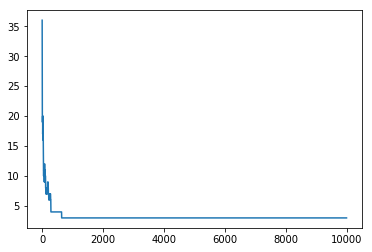

In [23]:
plt.plot(pos, fit)
plt.show()

En el siguiente gráfico se muestra la evolución del parámetro temperatura en las diferentes iteraciones.

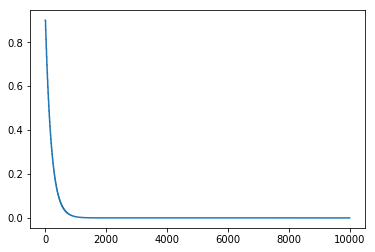

In [24]:
plt.plot(pos, temp)
plt.show()

Puesto que en el caso anterior el número de iteraciones máximo era 10.000, establecido como criterio de parada, no hemos conseguido llegar a un fitness = 0, quedámdnos en un valor mínimo de 3. Vamos a continuación a aumentar éste límite.

In [39]:
initialSol=initialSolSameRow
fitness = lambda x, _ : num_collisions(x)
initialTemp = lambda : 0.9
criterio_parada = lambda f,i : f==0 or i > 1000000
random_neighbor = oneRandomMove
update_temp = updateTempStandard
prob_aceptacion = prob_aceptacion_standard

In [43]:
sol, temp, pos, fit = queens(9)

In [41]:
sol

[(1, 5), (2, 2), (2, 7), (3, 9), (4, 1), (4, 1), (5, 8), (6, 4), (8, 3)]

In [42]:
fit[-1]

2

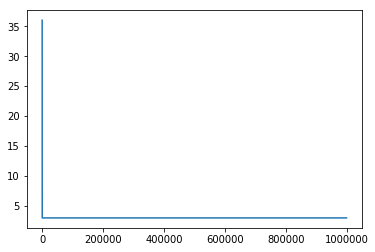

In [44]:
plt.plot(pos, fit)
plt.show()

Con un millón de iteraciones no conseguimos llegar a un fitness menor de 2.

## Caso A2) Tenemos en cuenta que debe haber una reina en cada fila y otra en cada columna, y consideramos sólo soluciones que cumplan esa propiedad.

### Codificación de las soluciones

Puesto que dos reinas colisionan cuando están en la misma columna, fila o diagonal esto significa que el problema a solucionar pasar por evitar que las reinas vayan en una misma fila. Al tratarse de $n$ reinas en un tablero de $n \times n$, esto significa que cada reina va en una de las filas del tablero, y sin perdida de generalidad se puede suponer que la reina $k$ se sitúa en la fila $k$. Del mismo modo, cada reina se tendrá que colocar en una columna diferente, y por lo tanto la función que asigna a la reina $i$ la columna $j$ en la que está situada es una biyección. Esto nos permite codificar las soluciones como biyecciones o permutaciones de $n$ elementos, reduciendo el espacio de búsqueda de un cardinal del orden de $(n^2)^n$ a uno de $n!$, y preocuparnos unícamente por las colisiones diagonales entre reinas.

Estas permutaciones o biyecciones las representamos como listas de $n$ elementos, donde el el elemento i-ésimo representa la columna en la que la reina de la fila $i$ esta situada. Por ejemplo, la permutación $(1,3,6,5,4,8,2,9,7)$ codificaría la solución con una reina en la fila 1 y columna 1, otra en la fila 2 y columna 3, otra en la fila 3 y columna 6, y así sucesivamente hasta una última reina en la fila 9 y columna 7. 

### Función objetivo

La función objetivo a minimizar será de nuevo el número de colisiones entre reinas, solo que en esta ocasión sólo necesitamos preocuparnos de las colisiones diagonales:

In [25]:
def num_collisions_perm(columns,n):
    
    positions = [(i+1,columns[i]) for i in range(n)]
    
    num_colls = 0
    
    for i in range(n):
        for j in range(i+1,n):
            queen1 = positions[i]
            queen2 = positions[j]
    
            if collision_perm(queen1,queen2):
                num_colls += 1
    return num_colls
    
def collision_perm(queen1,queen2):
    i1,j1 = queen1
    i2,j2 = queen2
    
    if i1-j1==i2-j2 or i1+j1==i2+j2:
        return True
    else:
        return False

### Entorno de un punto en el espacio de búsqueda

Proponemos el siguiente entorno para una solución: aquellas configuraciones obtenidas a través del intercambio de columnas entre dos reinas, es decir, transponiendo dos elementos cualesquiera de la permutación.

In [26]:
def oneRandomTransposition(permutation,n):
    new_sol = permutation[:] # copy
    i = randint(0,n-1)
    j = randint(0,n-1)
    new_sol[i] = permutation[j]
    new_sol[j] = permutation[i]
    return new_sol

# TODO: impedir transposiciones triviales (i==j). Suceden con probabilidad 1/n

De nuevo, el algoritmo podría mejorarse dando mayor probabilidad a las reinas que están en colisión.

### Configuración inicial

Como configuración inicial, usaremos simplemente una permutación aleatoria:

In [27]:
def initialSolRandom(n):
    np_sol = np.random.permutation(n) + 1
    return list(np_sol)

### Otros parámetros

Los demás parámetros del algoritmo, es decir, la temperatura inicial y su variación, la probabilidad de aceptación y el criterio de parada, serán los mismos considerados en el apartado anterior

### Algoritmo

In [ ]:
[i+1 for i in range(n)]

### Resultados

Para probar la implementación del algoritmo se ha resuelto el problema de las N reinas para distintos valores de N. Para cada tablero se ha lanzado 5 veces el programa. 

In [29]:
initialSol=initialSolRandom
fitness = num_collisions_perm
initialTemp = lambda : 0.9
criterio_parada = lambda f,i : f==0 or i > 10000
random_neighbor = oneRandomTransposition
update_temp = updateTempStandard
prob_aceptacion = prob_aceptacion_standard

In [30]:
sol, temp, pos, fit = queens(9)

In [31]:
sol

[3, 6, 9, 7, 4, 1, 8, 2, 5]

In [32]:
fit[-1]

0

Se muestra en el gráfico siguiente la evolución del valor de la función fitness a lo largo de las iteraciones.

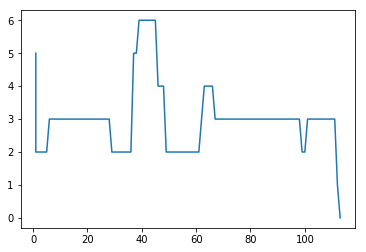

In [33]:
plt.plot(pos, fit)
plt.show()

En el siguiente gráfico se muestra la evolución del parámetro temperatura en las diferentes iteraciones.

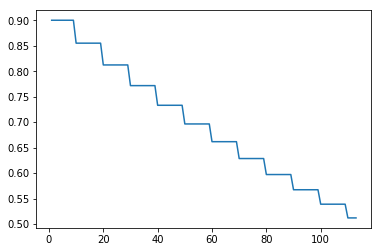

In [34]:
plt.plot(pos, temp)
plt.show()

En este caso hemos conseguido alcanzar fitness = 0 en menos de 200 iteraciones.